In [1]:
import numpy as np

import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG
from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.tools.euler_number import euler_number_along_zero_ax

from sigcorr.tools.stats.utils import pval2sig
from sigcorr.tools.stats.utils import sig2pval

from sigcorr.tools.stats.gp.upcross import gp_upcross_at_level
from sigcorr.tools.stats.gp.euler_number import GPEulerNumberPropagator

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import EulerNumberCalc
from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import OverflowsCalc
from sigcorr.mapreduce.map_reducers import ChainCalc
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.models.gross_vitells import GrossVitells
from sigcorr.models.gross_vitells_asimov import GrossVitellsAsimov
from sigcorr.models.hyy import Hyy
from sigcorr.models.hyy_asimov import HyyAsimov
from sigcorr.models.hyy_2d import Hyy2D
from sigcorr.models.hyy_2d_asimov import Hyy2DAsimov
from sigcorr.models.utils import set_params_from_file


CFG.FITTER.bfit_pool_size = 60  # gp draws use this pool size

set_plt_reasonable_defaults(plt)

In [2]:
#input_file = "../../output/hyy2d-2560.h5"
input_file = "../../output/hyy-1m.h5"
#input_file = "../../output/gross_vitells200k-1m.h5"
asimov_input_file = input_file.split("-")[0] + "-asimov.h5"

In [3]:
true_model = Hyy(None)
set_params_from_file(true_model, input_file)
true_model.init()

In [4]:
true_res_part = {}
with h5py.File(input_file, "r", swmr=True) as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        true_res_part[field] = f[field][:10_000, ...]
    #true_res_part["sig_std"] = f.attrs["sig_std"]

In [5]:
asimov_model = HyyAsimov(true_model.xs)
set_params_from_file(asimov_model, asimov_input_file)
asimov_model.init()

In [6]:
asimov_res = {}
with h5py.File(input_file.split("-")[0] + "-asimov.h5", "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        asimov_res[field] = f[field][...]

In [7]:
asimov_samples = asimov_res["bg_samples"]

In [8]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 677851.54it/s]


In [9]:
asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(override_x=np.array(0)), asimov_covcalc.get_cov_stat_err(override_x=np.array(0))
asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 4073721.83it/s]


In [10]:
LOCAL_SIG_GRID = np.arange(0, 7.05, 0.1)
LOCAL_SIG_SQR_GRID = np.arange(0, LOCAL_SIG_GRID[-1]**2, 0.5)

In [11]:
c0 = LOCAL_SIG_GRID[7]

In [12]:
asimov_gp_euler_number_covcalc0, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 3_000_000, 300, true_res_part["scan_xs"].shape[:-1], EulerNumberCalc(c0), BatchStats1Reduce()))
asimov_gp_euler_number0, asimov_gp_euler_number_err0 = asimov_gp_euler_number_covcalc0.get_mean(), asimov_gp_euler_number_covcalc0.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [00:07<00:00, 391525.16it/s]


In [13]:
asimov_gp_euler_number0

array([1.632339])

In [14]:
propagator = GPEulerNumberPropagator(np.array([c0]), np.array([asimov_gp_euler_number0]))

In [15]:
gv_p0_upper_bound = propagator.calc(LOCAL_SIG_GRID).ravel()

In [16]:
true_euler_number_covcalc0, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 20000, ChainCalc([SigsCalc(), EulerNumberCalc(c0)]), BatchStats1Reduce()))
true_euler_number0, true_euler_number_err0 = true_euler_number_covcalc0.get_mean(), true_euler_number_covcalc0.get_stat_err()

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:00<00:00, 6055768.52it/s]


In [17]:
true_euler_number0

array([1.630591])

In [18]:
true_p0_bs, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 20000, ChainCalc([SigsCalc(), OverflowsCalc(LOCAL_SIG_GRID)]), BatchStats1Reduce()))
true_p0, true_p0_err = true_p0_bs.get_mean(), true_p0_bs.get_stat_err()

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:00<00:00, 1302946.70it/s]


In [19]:
true_p0

array([1.00000e+00, 1.00000e+00, 9.99990e-01, 9.99835e-01, 9.98798e-01,
       9.95406e-01, 9.87081e-01, 9.71251e-01, 9.45953e-01, 9.10165e-01,
       8.63887e-01, 8.07725e-01, 7.44771e-01, 6.76732e-01, 6.05924e-01,
       5.35575e-01, 4.67105e-01, 4.02413e-01, 3.42320e-01, 2.86948e-01,
       2.38349e-01, 1.95637e-01, 1.58769e-01, 1.27421e-01, 1.01200e-01,
       7.93080e-02, 6.15360e-02, 4.73490e-02, 3.61700e-02, 2.72500e-02,
       2.02260e-02, 1.48150e-02, 1.08100e-02, 7.75600e-03, 5.53900e-03,
       3.86300e-03, 2.75100e-03, 1.96100e-03, 1.31800e-03, 8.92000e-04,
       6.12000e-04, 4.18000e-04, 2.82000e-04, 1.89000e-04, 1.27000e-04,
       7.50000e-05, 5.00000e-05, 3.20000e-05, 2.10000e-05, 1.20000e-05,
       9.00000e-06, 7.00000e-06, 3.00000e-06, 2.00000e-06, 1.00000e-06,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.000

In [20]:
true_p0_err

array([9.99999500e-04, 9.99999500e-04, 9.99994500e-04, 9.99916997e-04,
       9.99398320e-04, 9.97699859e-04, 9.93519011e-04, 9.85520196e-04,
       9.72600692e-04, 9.54025247e-04, 9.29454815e-04, 8.98734859e-04,
       8.63000837e-04, 8.22636944e-04, 7.78410967e-04, 7.31829702e-04,
       6.83450643e-04, 6.34360180e-04, 5.85081091e-04, 5.35675198e-04,
       4.88209938e-04, 4.42308672e-04, 3.98458247e-04, 3.56960759e-04,
       3.18119458e-04, 2.81616750e-04, 2.48064500e-04, 2.17598249e-04,
       1.90184118e-04, 1.65075738e-04, 1.42218141e-04, 1.21716884e-04,
       1.03971149e-04, 8.80681551e-05, 7.44244581e-05, 6.21530368e-05,
       5.24499761e-05, 4.42831796e-05, 3.63042697e-05, 2.98663690e-05,
       2.47386337e-05, 2.04450483e-05, 1.67928556e-05, 1.37477271e-05,
       1.12694277e-05, 8.66025404e-06, 7.07106781e-06, 5.65685425e-06,
       4.58257569e-06, 3.46410162e-06, 3.00000000e-06, 2.64575131e-06,
       1.73205081e-06, 1.41421356e-06, 1.00000000e-06, 0.00000000e+00,
      

In [21]:
gp_p0_bs, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 3_000_000, 10_000, true_res_part["scan_xs"].shape[:-1], OverflowsCalc(LOCAL_SIG_GRID), BatchStats1Reduce()))
gp_p0, gp_p0_err = gp_p0_bs.get_mean(), gp_p0_bs.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [00:03<00:00, 814184.34it/s]


In [22]:
deviation = 10*(asimov_corr - true_corr)
deviation[np.eye(deviation.shape[0]).astype(bool)] = 0

In [23]:
gp_p0UP_bs, _ = get_last_from_iter(gp_batch_mapreduce(true_cov + deviation, 3_000_000, 10_000, true_res_part["scan_xs"].shape[:-1], OverflowsCalc(LOCAL_SIG_GRID), BatchStats1Reduce()))
gp_p0UP, gp_p0UP_err = gp_p0UP_bs.get_mean(), gp_p0UP_bs.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [00:03<00:00, 763383.73it/s]


In [24]:
gp_p0DOWN_bs, _ = get_last_from_iter(gp_batch_mapreduce(true_cov - deviation, 3_000_000, 10_000, true_res_part["scan_xs"].shape[:-1], OverflowsCalc(LOCAL_SIG_GRID), BatchStats1Reduce()))
gp_p0DOWN, gp_p0DOWN_err = gp_p0DOWN_bs.get_mean(), gp_p0DOWN_bs.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [00:03<00:00, 805182.64it/s]


In [25]:
LOCAL_PVALS = sig2pval(LOCAL_SIG_GRID)

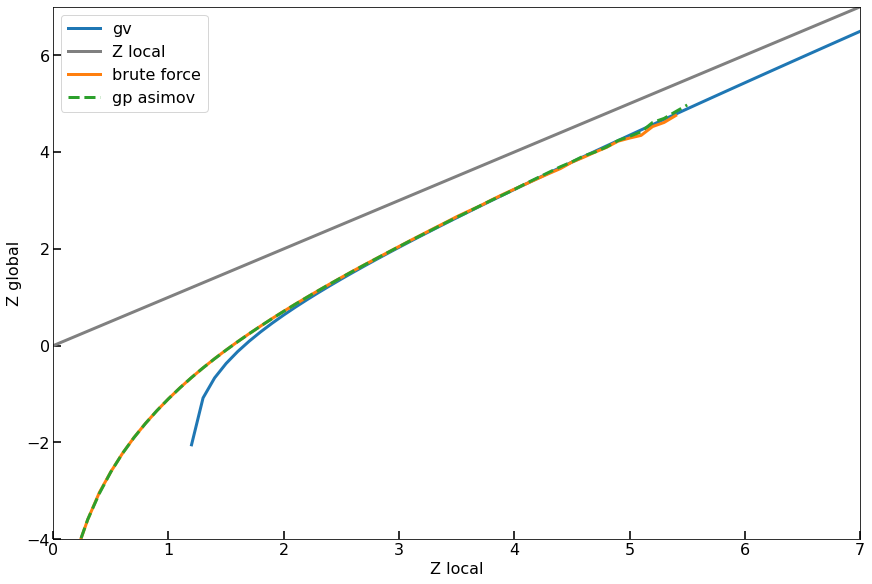

In [26]:
plt.plot(LOCAL_SIG_GRID, pval2sig(gv_p0_upper_bound), label="gv")
plt.plot(LOCAL_SIG_GRID, LOCAL_SIG_GRID, color="gray", label="Z local")
plt.plot(LOCAL_SIG_GRID, pval2sig(true_p0), ls="-", label="brute force")
plt.plot(LOCAL_SIG_GRID, pval2sig(gp_p0), ls="--", label="gp asimov")
plt.legend()
plt.ylim(-4, 7)
plt.xlim(0, 7);
plt.ylabel("Z global")
plt.xlabel("Z local");

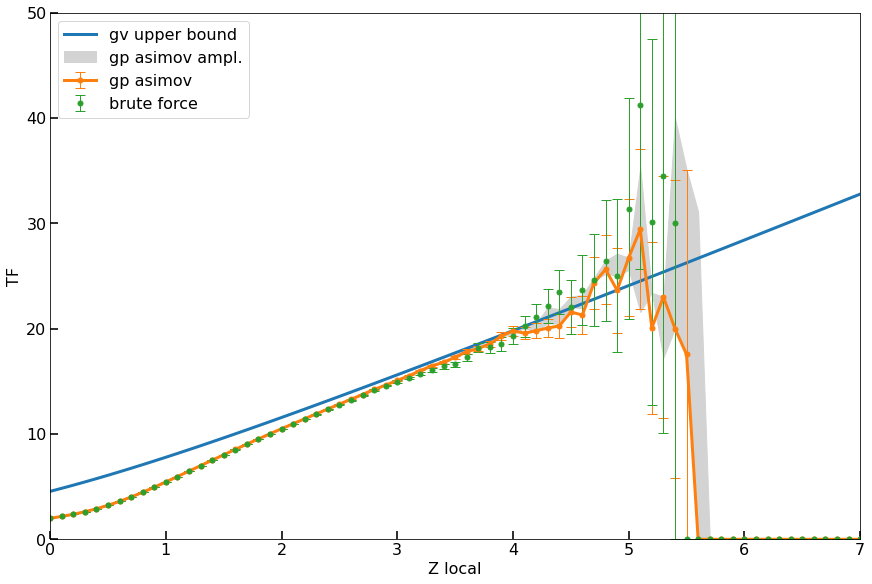

In [27]:
plt.plot(LOCAL_SIG_GRID, gv_p0_upper_bound/LOCAL_PVALS, label="gv upper bound")
#plt.plot(LOCAL_SIG_GRID, LOCAL_SIG_GRID, color="gray", label="Z local")
plt.fill_between(LOCAL_SIG_GRID, np.min([gp_p0DOWN, gp_p0UP], axis=0)/LOCAL_PVALS, np.max([gp_p0DOWN, gp_p0UP], axis=0)/LOCAL_PVALS, color="lightgray", label="gp asimov ampl.")
plt.errorbar(LOCAL_SIG_GRID, gp_p0/LOCAL_PVALS, ls="-", yerr=gp_p0_err/LOCAL_PVALS, elinewidth=1, marker="o", capsize=5, label="gp asimov")
plt.errorbar(LOCAL_SIG_GRID, true_p0/LOCAL_PVALS, yerr=true_p0_err/LOCAL_PVALS, ls="", marker="o", capsize=5, elinewidth=1, label="brute force")
#plt.axhline((true_res_part["scan_xs"][-1] - true_res_part["scan_xs"][0])/true_res_part["sig_std"], color="gray", label="$\Delta m/\sigma_m$")
#plt.plot(LOCAL_SIG_GRID, direct_asimov_p0_upper_bound/LOCAL_PVALS, ls="--", label="direct asimov upper bound")
plt.legend()
#plt.yscale("log")
plt.ylim(0, 50)
plt.xlim(0, 7);
plt.ylabel("TF")
plt.xlabel("Z local");

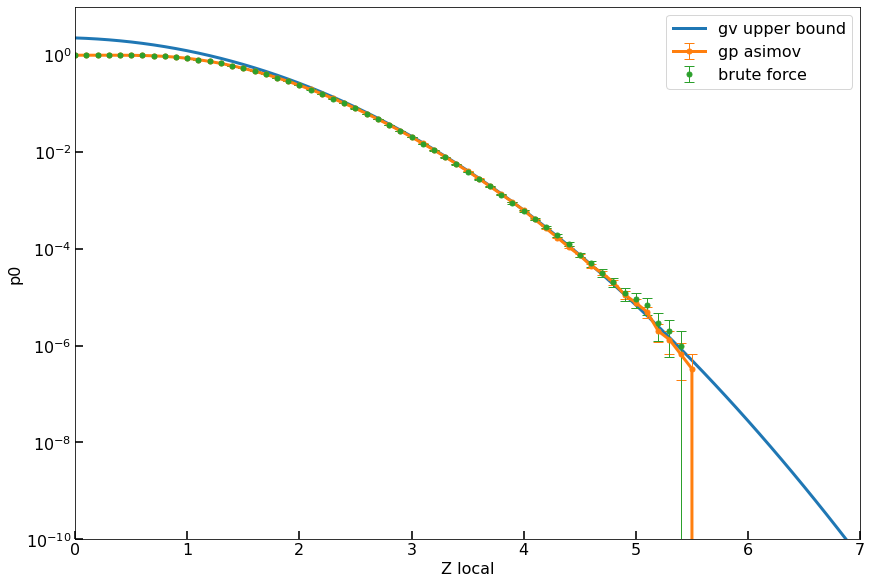

In [28]:
plt.plot(LOCAL_SIG_GRID, gv_p0_upper_bound, label="gv upper bound")
plt.errorbar(LOCAL_SIG_GRID, gp_p0, ls="-", yerr=gp_p0_err, elinewidth=1, marker="o", capsize=5, label="gp asimov")
plt.errorbar(LOCAL_SIG_GRID, true_p0, yerr=true_p0_err, ls="", marker="o", capsize=5, elinewidth=1, label="brute force")
#plt.plot(LOCAL_SIG_GRID, direct_asimov_p0_upper_bound, ls="--", label="direct asimov upper bound")
plt.legend()
plt.yscale("log")
plt.ylim(1E-10, 10)
plt.xlim(0, 7);
plt.ylabel("p0")
plt.xlabel("Z local");